<a href="https://colab.research.google.com/github/Ibraheem101/Made-With-ML/blob/dev/notebooks/mwml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MLOPs**

## **Setup**

### **Clone Github repository**

In [1]:
! git clone https://github.com/GokuMohandas/Made-With-ML.git

Cloning into 'Made-With-ML'...
remote: Enumerating objects: 192, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 192 (delta 36), reused 69 (delta 30), pack-reused 102
Receiving objects: 100% (192/192), 4.27 MiB | 8.70 MiB/s, done.
Resolving deltas: 100% (42/42), done.


In [1]:
! pwd

/content


In [2]:
import os
print(os.getcwd())

/content


In [3]:
new_directory = "/content/Made-With-ML"
os.chdir(new_directory)

In [4]:
print(os.getcwd())

/content/Made-With-ML


In [5]:
import sys
sys.path.append('/content/Made-With-ML')

### **Install requirements**

In [6]:
! pip install --upgrade pip setuptools wheel

In [7]:
pip install -r requirements.txt

In [8]:
! pre-commit install
! pre-commit autoupdate

pre-commit installed at .git/hooks/pre-commit
Updating https://github.com/pre-commit/pre-commit-hooks ... [INFO] Initializing environment for https://github.com/pre-commit/pre-commit-hooks.
updating v4.4.0 -> v4.5.0.


In [9]:
import os
import re
import json
import math
import nltk
import time
import torch
import gensim
import random
import urllib
import warnings
import itertools
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [10]:
# Support for third party widgets
from google.colab import output
output.enable_custom_widget_manager()

### **Ray Setup**

In [11]:
import ray

In [12]:
# Initialize Ray
if ray.is_initialized():
    ray.shutdown()
ray.init()

2023-10-09 07:18:35,720	INFO worker.py:1633 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.10.12
Ray version:,2.7.0
Dashboard:,http://127.0.0.1:8265


In [13]:
ray.cluster_resources()

{'CPU': 2.0,
 'object_store_memory': 3917211648.0,
 'memory': 7834423296.0,
 'node:__internal_head__': 1.0,
 'node:172.28.0.12': 1.0}

In [14]:
# Workers (1 g4dn.xlarge)
num_workers = 1
resources_per_worker={"CPU": 1, "GPU": 0}

## **Data**

In [15]:
import pandas as pd

In [16]:
# Data ingestion
DATASET_LOC = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/dataset.csv"
df = pd.read_csv(DATASET_LOC)
df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other
4,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",other


In [17]:
df.tag.unique()

array(['computer-vision', 'other', 'natural-language-processing', 'mlops'],
      dtype=object)

### **Data Splitting**

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
# Value counts
df.tag.value_counts()

tag
natural-language-processing    310
computer-vision                285
other                          106
mlops                           63
Name: count, dtype: int64

What are the criteria we should focus on to ensure proper data splits?
* Randomness
* Stratification (for imbalanced datasets)
* Sufficient data size in each subset
* Temporal data handling (for time-series data)
* Consistency across models
* Reproducibility with random seed
* Adequate validation set size for hyperparameter tuning
* Complete separation of the test set from training and validation data.

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 764 entries, 0 to 763
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           764 non-null    int64 
 1   created_on   764 non-null    object
 2   title        764 non-null    object
 3   description  764 non-null    object
 4   tag          764 non-null    object
dtypes: int64(1), object(4)
memory usage: 30.0+ KB


In [21]:
test_size = 0.2
train_df, val_df = train_test_split(df, stratify=df.tag, test_size=test_size, random_state=1234)

In [22]:
train_df.tag.value_counts()

tag
natural-language-processing    248
computer-vision                228
other                           85
mlops                           50
Name: count, dtype: int64

In [23]:
val_df.tag.value_counts()

tag
natural-language-processing    62
computer-vision                57
other                          21
mlops                          13
Name: count, dtype: int64

In [24]:
# Validation (adjusted) value counts
val_df.tag.value_counts() * int((1-test_size) / test_size)

tag
natural-language-processing    248
computer-vision                228
other                           84
mlops                           52
Name: count, dtype: int64

### **Exploratory Data Analysis**

In [25]:
from collections import Counter
from wordcloud import WordCloud, STOPWORDS

In [26]:
all_tags = Counter(df.tag)
all_tags.most_common()

[('natural-language-processing', 310),
 ('computer-vision', 285),
 ('other', 106),
 ('mlops', 63)]

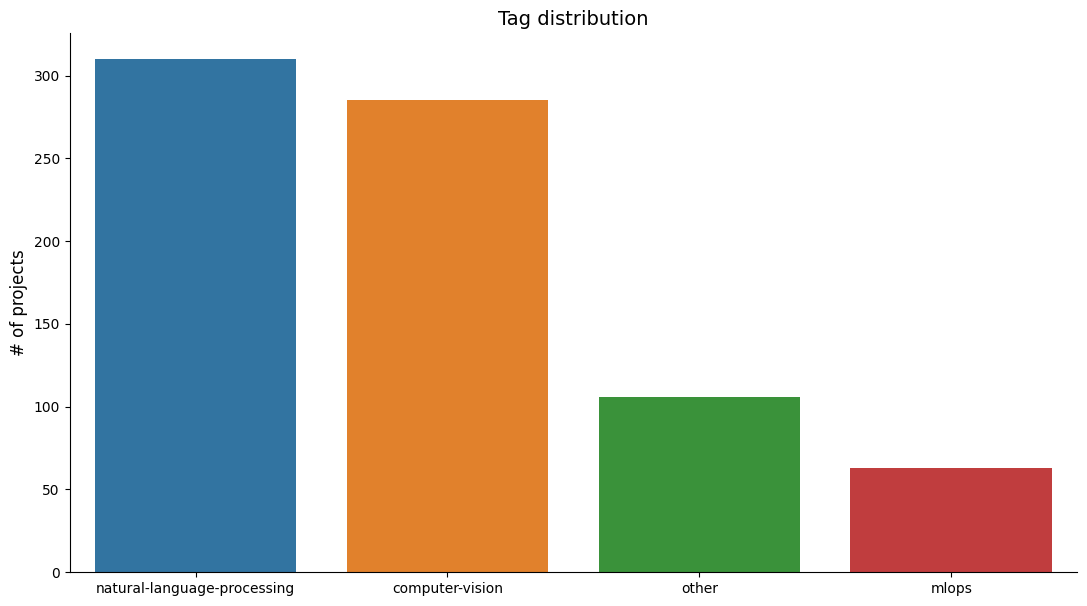

In [27]:
tags, tag_counts = zip(*all_tags.most_common())
plt.figure(figsize=(13, 7))
sns.barplot(x=list(tags), y=list(tag_counts))
sns.despine()
plt.title("Tag distribution", fontsize=14)
plt.ylabel("# of projects", fontsize=12)
plt.show()
# plt.xticks(rotation=45)

There's some data imbalance but we'll deal with that before modeling

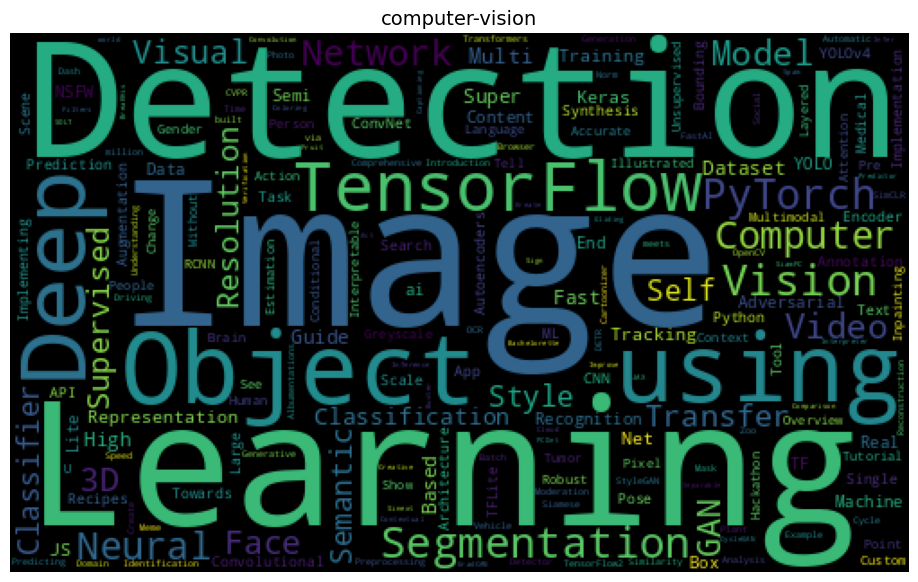

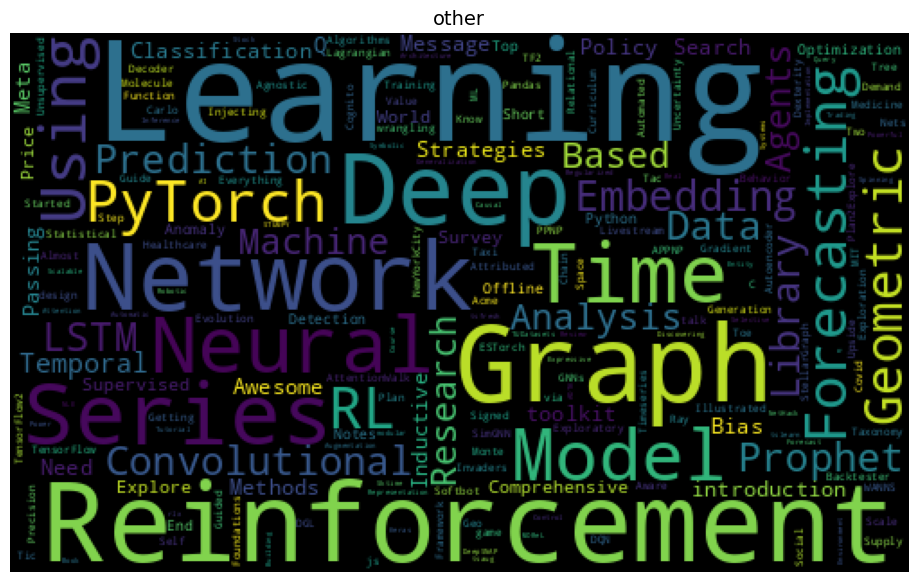

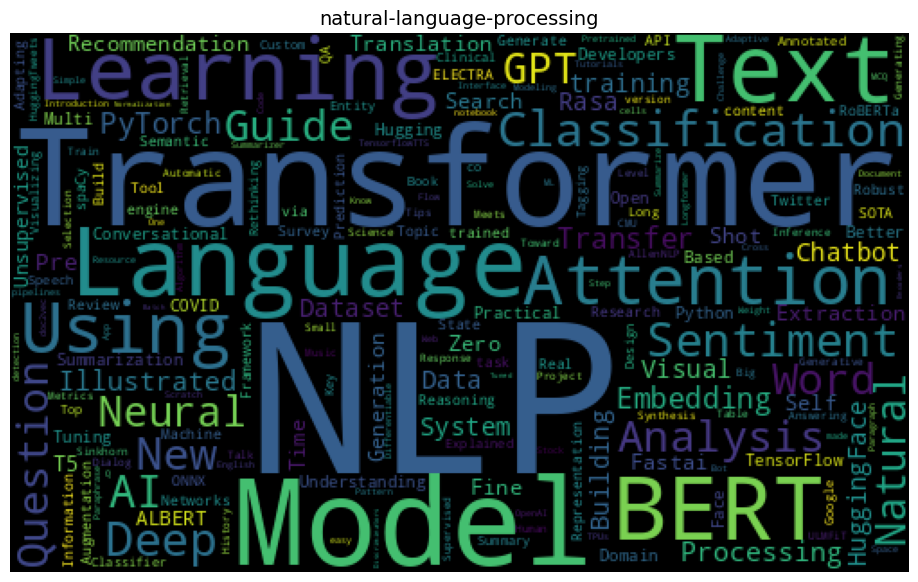

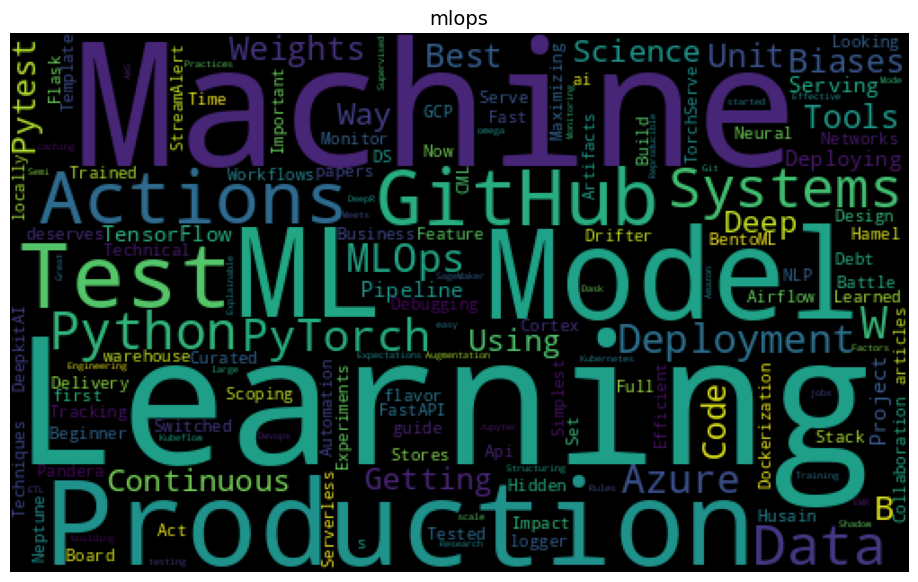

In [28]:
# Examine word distribution
# Create a list to store the generated WordCloud plots
cloud_plots = []

for tag in df['tag'].unique():
    plt.figure(figsize=(13, 7))
    subset = df[df.tag==tag]
    text = subset.title.values
    cloud = WordCloud(
        stopwords=STOPWORDS, background_color='black', collocations=False,
        width=500, height=300).generate(" ".join(text)) #function requires a single string as input
    plt.axis("off")
    plt.imshow(cloud)
    plt.title(tag, fontsize=14)
    cloud_plots.append(plt)  # Store the current plot

# Adjust spacing between subplots
plt.subplots_adjust(wspace=2, hspace=0.5)

# Display all the plots
plt.show()


### **Preprocessing**

In [29]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [30]:
df.iloc[0]

id                                                             6
created_on                                   2020-02-20 06:43:18
title          Comparison between YOLO and RCNN on real world...
description    Bringing theory to experiment is cool. We can ...
tag                                              computer-vision
Name: 0, dtype: object

#### **Feature engineering**

Here, we could use a project's title and description separately as features but we'll combine them to create one input feature.

In [31]:
df['text'] = df['title'] + ' ' + df['description']

#### **Cleaning**

In [32]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [33]:
def clean_text(text, stopwords = STOPWORDS):
    # lowercase
    text = text.lower()

    # Remove stopwords
    pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub('', text)

    # Spacing and filters
    text = re.sub(r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text)  # add spacing
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends
    text = re.sub(r"http\S+", "", text)  #  remove links

    return text

In [34]:
original_df = df.copy()
df.text = df.text.apply(clean_text)
print (f"{original_df.text.values[0]}\n{df.text.values[0]}")

Comparison between YOLO and RCNN on real world videos Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.
comparison yolo rcnn real world videos bringing theory experiment cool easily train models colab find results minutes


In [35]:
df.head(2)

,id,created_on,title,description,tag,text
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision,comparison yolo rcnn real world videos bringin...
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision,show infer tell contextual inference creative ...


In [36]:
# Drop unwanted columns
df.drop(columns = ['id', 'created_on', 'title', 'description'], errors='ignore')
df = df.dropna(subset=["tag"])  # drop nulls
df = df[['text', 'tag']]
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,computer-vision
1,show infer tell contextual inference creative ...,computer-vision
2,awesome graph classification collection import...,other
3,awesome monte carlo tree search curated list m...,other
4,attentionwalk pytorch implementation watch ste...,other


#### **Label Encoding**

In [37]:
tags = df.tag.unique().tolist()
num_classes = len(tags)

class_to_index = {tag : i for i, tag in enumerate(tags)}
class_to_index

{'computer-vision': 0,
 'other': 1,
 'natural-language-processing': 2,
 'mlops': 3}

In [38]:
# Encode labels
df['tag'] = df['tag'].map(class_to_index)
df['tag'].iloc[:5]

0    0
1    0
2    1
3    1
4    1
Name: tag, dtype: int64

In [39]:
# Decoding function
def decode(indices, index_to_class):
    return [index_to_class[index] for index in indices]

In [40]:
index_to_class = {value : key for key, value in class_to_index.items()}
decode(df['tag'].iloc[:5], index_to_class)

['computer-vision', 'computer-vision', 'other', 'other', 'other']

#### **Tokenize**

In [41]:
from transformers import BertTokenizer

In [42]:
# Bert tokenizer
tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
text = "Transfer learning with transformers for text classification."
encoded_inputs = tokenizer([text], return_tensors="np", padding="longest")  # pad to longest item in batch
print ("input_ids:", encoded_inputs["input_ids"])
print ("attention_mask:", encoded_inputs["attention_mask"])
print (tokenizer.decode(encoded_inputs["input_ids"][0]))

input_ids: [[  102  2268  1904   190 29155   168  3267  2998   205   103]]
attention_mask: [[1 1 1 1 1 1 1 1 1 1]]
[CLS] transfer learning with transformers for text classification. [SEP]


In [43]:
def tokenize(batch):
    tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    encoded_inputs = tokenizer(batch["text"].tolist(), return_tensors="np", padding="longest")
    return dict(ids=encoded_inputs["input_ids"], masks=encoded_inputs["attention_mask"], targets=np.array(batch["tag"]))

In [44]:
# Tokenization
tokenize(df.head(1))

{'ids': array([[  102,  2029,  1778,   609,  6446,  4857,  1332,  2399, 13572,
         19125,  1983,  1954,  6240,  3717,  7434,  1262,   537,   201,
          1040,   545,  4714,   103]]),
 'masks': array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 'targets': array([0])}

Combine preprocessing operations

In [45]:
def preprocess(df, class_to_index):
    """Preprocess the data."""
    df["text"] = df.title + " " + df.description  # feature engineering
    df["text"] = df.text.apply(clean_text)  # clean text
    df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # clean dataframe
    df = df[["text", "tag"]]  # rearrange columns
    df["tag"] = df["tag"].map(class_to_index)  # label encoding
    outputs = tokenize(df)
    return outputs

In [46]:
# Apply
preprocess(df=train_df, class_to_index=class_to_index)

{'ids': array([[  102,   856,   532, ...,     0,     0,     0],
        [  102,  2177, 29155, ...,     0,     0,     0],
        [  102,  2180,  3241, ...,     0,     0,     0],
        ...,
        [  102,   453,  2068, ...,  5730,   432,   103],
        [  102, 11268,  1782, ...,     0,     0,     0],
        [  102,  1596,   122, ...,     0,     0,     0]]),
 'masks': array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 'targets': array([3, 2, 2, 2, 2, 0, 2, 0, 1, 2, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 3, 2,
        2, 2, 2, 2, 0, 2, 0, 3, 1, 0, 3, 2, 2, 2, 2, 0, 2, 2, 3, 0, 1, 1,
        1, 3, 0, 2, 1, 1, 2, 2, 2, 2, 0, 2, 0, 0, 0, 1, 0, 2, 2, 1, 2, 3,
        2, 0, 0, 0, 1, 0, 1, 0, 1, 0, 2, 2, 1, 1, 1, 2, 2, 0, 1, 3, 2, 2,
        2, 2, 1, 1, 3, 0, 1, 0, 0, 2, 2, 1, 0, 1, 2, 2, 2, 2, 0, 3, 3, 0,
        2, 2, 0, 0, 2, 2, 3, 1, 2

### **Distributed**

#### **Setup**

By default, the preserve_order option is set to False, which allows Ray to execute operations in parallel and potentially optimize the execution for better performance. However, when you set it to True, Ray will prioritize maintaining the order of data, which may result in slower performance but deterministic output

In [47]:
ray.data.DatasetContext.get_current().execution_options.preserve_order = True  # deterministic

In [48]:
ds = ray.data.read_csv(DATASET_LOC)
ds = ds.random_shuffle(seed=1234)
ds.take(1)

2023-10-09 07:18:53,940	INFO read_api.py:406 -- To satisfy the requested parallelism of 4, each read task output is split into 4 smaller blocks.
2023-10-09 07:18:53,984	INFO dataset.py:2380 -- Tip: Use `take_batch()` instead of `take() / show()` to return records in pandas or numpy batch format.
2023-10-09 07:18:53,993	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2023-10-09 07:18:54,002	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-10-09 07:18:54,005	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

[{'id': 1151,
  'created_on': datetime.datetime(2020, 6, 3, 7, 25, 27),
  'title': 'Web Mining and Information theory',
  'description': 'Mining the Web and playing with Natural Language processing. Implementing Information retrieval System tasks. Going towards the NLP and Performing Machine Learning algorithms. Through these codes and problems, I have understood the information retrieval process of any search engine. These are very useful problems towards sentiment analysis.',
  'tag': 'natural-language-processing'}]

#### **Splitting**
Next, we'll split our dataset into our training and validation splits. Ray has a built-in train_test_split function but we're using a modified version so that we can stratify our split based on the tag column.

In [49]:
import sys
sys.path.append("..")
from madewithml.data import stratify_split

In [50]:
# Split dataset
test_size = 0.2
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

2023-10-09 07:19:00,122	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2023-10-09 07:19:00,125	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-10-09 07:19:00,127	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

In [51]:
train_ds

RandomShuffle
+- MapBatches(_filter_split)
   +- MapBatches(group_fn)
      +- Sort
         +- RandomShuffle
            +- Dataset(
                  num_blocks=4,
                  num_rows=764,
                  schema={
                     id: int64,
                     created_on: timestamp[s],
                     title: string,
                     description: string,
                     tag: string
                  }
               )

In [52]:
val_ds

RandomShuffle
+- MapBatches(_filter_split)
   +- MapBatches(group_fn)
      +- Sort
         +- RandomShuffle
            +- Dataset(
                  num_blocks=4,
                  num_rows=764,
                  schema={
                     id: int64,
                     created_on: timestamp[s],
                     title: string,
                     description: string,
                     tag: string
                  }
               )

#### **Preprocessing**
One of the advantages of using Ray is that we won't have to change anything to our original Pandas-based preprocessing function we implemented in the previous lesson. Instead, we can use it directly with Ray's map_batches utility to map our preprocessing function across batches in our data in a distributed manner.

In [53]:
output.enable_custom_widget_manager()

In [54]:
# Mapping
tags = train_ds.unique(column="tag")
class_to_index = {tag: i for i, tag in enumerate(tags)}

2023-10-09 07:19:01,294	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> LimitOperator[limit=1]
2023-10-09 07:19:01,296	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-10-09 07:19:01,298	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/16 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

2023-10-09 07:19:03,540	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> AllToAllOperator[Aggregate] -> TaskPoolMapOperator[MapBatches(<lambda>)]
2023-10-09 07:19:03,544	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-10-09 07:19:03,547	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/16 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/16 [00:00<?, ?it/s]

- Aggregate 11:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 12:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 13:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

In [55]:
# Distributed preprocessing
sample_ds = train_ds.map_batches(preprocess, fn_kwargs={"class_to_index": class_to_index}, batch_format="pandas")
sample_ds.show(1)

2023-10-09 07:19:05,323	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)] -> LimitOperator[limit=1]
2023-10-09 07:19:05,325	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-10-09 07:19:05,328	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/16 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

{'ids': array([  102,  6317, 21024, 30121, 11257, 15567,  6317, 21024, 30121,
        6317, 13749,  1904,   551,   791, 11257, 15567,   103,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0]), 'masks': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'targets': 0}


## **Model**

### **Training**

#### **Distributed training**

The progression of model complexity follows a logical path from simple to more complex models, with each step building upon the previous one. Let's go through the progression and explain each step:

Random Model: This is the simplest baseline you can establish. It serves as a reference point to understand how your model is performing. Since it predicts labels randomly, it's not expected to provide any meaningful results. Its primary purpose is to set the lowest possible benchmark for model performance.

Rule-Based Model: The rule-based model introduces a bit more structure. Instead of random predictions, it tries to capture patterns in the input text and predict labels based on predefined rules. This model is still quite simple and typically manually defined, making it useful for scenarios where some domain-specific patterns can be identified without machine learning.

Logistic Regression with TF-IDF Vectors: Logistic Regression is a basic machine learning algorithm that works well as an initial modeling attempt. By using TF-IDF (Term Frequency-Inverse Document Frequency) vectors from text, this model attempts to capture relationships between words and labels. It's a form of feature-based modeling where the model learns the weights of features (words) to predict labels.

CNN (Convolutional Neural Network): CNNs are typically used for image processing, but they can also be applied to text data. In this case, the model applies character filters over the text, capturing local patterns. It's a more complex model compared to logistic regression and can capture spatial relationships between characters, which can be useful for tasks like text classification.

Fine-Tune Language Model (LLM): Fine-tuning a pre-trained language model is a more advanced approach. Here, you take a large language model pre-trained on a massive amount of text and fine-tune it on your specific task. This leverages the model's ability to understand contextual information in language, potentially improving performance on your task.

This progression from simple to complex models is a recommended practice because it allows you to gradually test and build upon different levels of model sophistication. Starting simple helps you establish a baseline, understand data preprocessing and modeling workflows, and identify potential challenges. As you move towards more complex models, you gain insights into how different techniques impact performance, and you can address more nuanced aspects of your data and task.

It's worth noting that the choice of model depends on your specific task, the available data, and the complexity of relationships in your data. Starting with simpler models can also help you avoid overfitting and ensure that the increased complexity of the model brings real benefits to your task.

#### **Setup**

In [56]:
from ray.data.preprocessor import Preprocessor

In [57]:
def set_seeds(seed=42):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    eval("setattr(torch.backends.cudnn, 'deterministic', True)")
    eval("setattr(torch.backends.cudnn, 'benchmark', False)")
    os.environ["PYTHONHASHSEED"] = str(seed)

In [58]:
def load_data(num_samples=None):
    ds = ray.data.read_csv(DATASET_LOC)
    ds = ds.random_shuffle(seed=1234)
    ds = ray.data.from_items(ds.take(num_samples)) if num_samples else ds
    return ds

When working with very large datasets, it's a good idea to limit the number of samples in our dataset so that we can execute our code quickly and iterate on bugs, etc. This is why we have a num_samples input argument in our load_data function (None = no limit, all samples).

Faster Development Iteration: Large datasets can slow down the development and debugging process because running operations on the entire dataset can take a significant amount of time. By limiting the number of samples using the num_samples parameter, you can quickly execute your code, identify bugs, and test changes without waiting for the entire dataset to process.

Memory Efficiency: Loading and processing large datasets into memory can consume a substantial amount of memory resources. Limiting the number of samples allows you to work within memory constraints, making your code more efficient and preventing memory-related issues.

Exploratory Analysis: When exploring a dataset, you might not need to analyze every single data point. By selecting a representative subset of samples, you can perform exploratory analysis, understand the data's characteristics, and make initial observations more efficiently.

Debugging: Debugging code is easier with a smaller dataset since you can quickly identify errors and iterate on fixes. Once your code is working as expected, you can scale up to the entire dataset.

Code Validation: Before running your code on the entire dataset, it's a good practice to validate its correctness using a smaller sample. This helps catch issues early and ensures that your code behaves as intended.

However, keep in mind that using a subset of the data might not capture all the characteristics of the full dataset. Therefore, after validating and debugging your code with a limited number of samples, it's essential to test it on the full dataset to ensure it works properly in all scenarios.







#### **Model**

Now we're ready to start defining our model architecture. We'll start by loading a pretrained LLM and then defining the components needed for fine-tuning it on our dataset. Our pretrained LLM here is a transformer-based model that has been pretrained on a large corpus of scientific text called scibert.

![](https://media.arxiv-vanity.com/render-output/7086622/bert_pretraining.png)

In [59]:
from transformers import BertModel

In [60]:
llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
embedding_dim = llm.config.hidden_size

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Once our model is loaded, we can tokenize an input text, convert it to torch tensors and pass it through our model to get a sequence and pooled representation of the text.

In [61]:
# Sample
text = ["BERT is a transformer model"]
batch = tokenizer(text, return_tensors="np", padding="longest")

In [62]:
{k:torch.tensor(v) for k,v in batch.items()}  # convert to torch tensors

{'input_ids': tensor([[  102, 24921,   165,   106, 14982,   437,   103]]),
 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0]]),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}

In [63]:
batch = {k:torch.tensor(v) for k,v in batch.items()}  # convert to torch tensors

In [64]:
seq, pool = llm(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])

In [65]:
seq.shape, pool.shape

(torch.Size([1, 7, 768]), torch.Size([1, 768]))

1. Text Tokenization: The input text, "Transfer learning with transformers for text classification," is tokenized. This means it's split into smaller parts, usually words or subwords, which are called tokens. This tokenization is necessary because the language model understands text at the token level.

2. Batch Processing: The tokenized text is processed as a batch (a group of sentences or texts). In this case, there's only one text in the batch.

3. Model Input: The tokenized batch is then converted into a format that the pre-trained language model can understand. This format includes two main components:

* input_ids: These are numerical representations of the tokens. Each token is mapped to a unique ID.
* attention_mask: This mask tells the model which parts of the input are actual tokens and which are padding. Padding is added to make all input sequences the same length.
4. Passing Through the Language Model: The tokenized and formatted batch is passed through the pre-trained language model (LLM). This LLM has learned to understand the context and meaning of words and text.

5. Output: After passing through the LLM, you get two main outputs:

* seq: This represents the sequence of hidden states, which essentially means a representation of the input text after each token. It's like having a snapshot of the text's meaning after every word.
* pool: This represents a "pooled" or combined representation of the entire text. It condenses the information from the entire sequence into a single representation. This pooled representation is often used as input for downstream tasks like classification.
6. Classification Layer: Finally, this pooled representation (pool) is passed through a linear classifier (in this case, referred to as fc1). This classifier is trained to take the pooled representation and predict which class or category the input text belongs to. The number of classes is determined by num_classes.

In summary, the code tokenizes the text, passes it through a pre-trained language model to get both a sequence-level and a pooled representation of the text, and then uses these representations to classify the text into one of several possible categories or classes. The seq is like a detailed understanding of the text at each word, while pool is a condensed understanding of the entire text.






In [66]:
class FinetunedLLM(nn.Module):
    def __init__(self, llm, dropout_p, embedding_dim, num_classes):
        super(FinetunedLLM, self).__init__()
        self.llm = llm
        self.dropout = nn.Dropout(dropout_p)
        self.fc1 = nn.Linear(embedding_dim, num_classes)

    def forward(self, batch):
        ids, masks = batch["ids"], batch["masks"]
        seq, pool = self.llm(input_ids=ids, attention_mask=masks)
        z = self.dropout(pool)
        z = self.fc1(z)
        return z

    @torch.inference_mode()
    def predict(self, batch):
        self.eval()
        z = self(inputs)
        y_pred = torch.argmax(z, dim=1).cpu().numpy()
        return y_pred

    @torch.inference_mode()
    def predict_proba(self, batch):
        self.eval()
        z = self(batch)
        y_probs = F.softmax(z).cpu().numpy()
        return y_probs


In [67]:
model = FinetunedLLM(llm=llm, dropout_p=0.5, embedding_dim=embedding_dim, num_classes=num_classes)
print(model.named_parameters)

<bound method Module.named_parameters of FinetunedLLM(
  (llm): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

We can iterate through our dataset in batches however we may have batches of different sizes. Recall that our tokenizer padded the inputs to the longest item in the batch (padding="longest"). However, our batches for training will be smaller than our large data processing batches and so our batches here may have inputs with different lengths.

In [68]:
from transformers import DataCollatorWithPadding

In [69]:
# data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [70]:
# # Sample batch
# sample_batch = sample_ds.take_batch(batch_size=128)
# data_collator(sample_batch)

In [71]:
from ray.train.torch import get_device

Created a temporary directory at /tmp/tmpfkzuifqv
Writing /tmp/tmpfkzuifqv/_remote_module_non_scriptable.py


In [72]:
def pad_array(arr, dtype=np.int32):
    max_len = max(len(row) for row in arr)
    padded_arr = np.zeros((arr.shape[0], max_len), dtype=dtype)
    for i, row in enumerate(arr):
        padded_arr[i][:len(row)] = row
    return padded_arr

In [73]:
def collate_fn(batch):
    batch["ids"] = pad_array(batch["ids"])
    batch["masks"] = pad_array(batch["masks"])
    dtypes = {"ids": torch.int32, "masks": torch.int32, "targets": torch.int64}
    tensor_batch = {}
    for key, array in batch.items():
        tensor_batch[key] = torch.as_tensor(array, dtype=dtypes[key], device=get_device())
    return tensor_batch

In [74]:
# Sample batch
sample_batch = sample_ds.take_batch(batch_size=128)
collate_fn(sample_batch)

2023-10-09 07:19:19,555	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)] -> LimitOperator[limit=128]
2023-10-09 07:19:19,558	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-10-09 07:19:19,560	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/16 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

<ipython-input-73-d06568f052eb>:7: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  tensor_batch[key] = torch.as_tensor(array, dtype=dtypes[key], device=get_device())


{'ids': tensor([[  102,  6317, 21024,  ...,     0,     0,     0],
         [  102,  2762,   784,  ...,     0,     0,     0],
         [  102, 10850,   142,  ...,     0,     0,     0],
         ...,
         [  102,  5363, 14440,  ...,     0,     0,     0],
         [  102,  3942,  8837,  ...,     0,     0,     0],
         [  102,   504,  3657,  ...,     0,     0,     0]], dtype=torch.int32),
 'masks': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]], dtype=torch.int32),
 'targets': tensor([0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 2, 2, 1, 0, 2, 2, 0, 2, 2, 2, 0, 3, 0, 2,
         2, 0, 2, 2, 1, 3, 0, 0, 0, 3, 1, 2, 2, 2, 1, 2, 2, 0, 0, 0, 0, 0, 1, 2,
         0, 3, 3, 2, 0, 3, 2, 3, 2, 3, 0, 0, 3, 2, 2, 1, 0, 0, 0, 0, 1, 2, 0, 3,
         3, 0, 0, 2, 0, 3, 0, 2, 2, 0, 0, 0, 3, 3, 2, 2, 0, 0, 3, 2, 2, 0, 2, 2,
         2, 0, 

#### **Utilities**


![](https://madewithml.com/static/images/mlops/ray/train.svg)

In [75]:
import ray.train as train
from ray.air import Checkpoint, session
from ray.air.config import CheckpointConfig, DatasetConfig, RunConfig, ScalingConfig
from ray.train.torch import TorchCheckpoint, TorchTrainer

We'll start by defining what one step (or iteration) of training looks like. This will be a function that takes in a batch of data, a model, a loss function, and an optimizer. It will then perform a forward pass, compute the loss, and perform a backward pass to update the model's weights. And finally, it will return the loss.

In [76]:
def train_step(ds, batch_size, model, num_classes, loss_fn, optimizer):
    model.train()
    loss = 0.0
    ds_generator = ds.iter_torch_batches(batch_size=batch_size, collate_fn=collate_fn)
    for i, batch in enumerate(ds_generator):
        optimizer.zero_grad()
        z = model(batch)
        targets = F.one_hot(batch["targets"], num_classes=num_classes).float() # one-hot (for loss_fn)
        J = loss_fn(z, targets)
        J.backward()
        optimizer.step()
        loss += (J.detach().item() - loss) / (i + 1)  # cumulative loss
        return loss

* model.train(): This line tells the machine learning model that it's in training mode. During training, the model learns from data and adjusts its parameters to make better predictions.

* loss = 0.0: This initializes a variable called loss to zero. It will be used to keep track of the cumulative loss during one training iteration.

* ds_generator = ds.iter_torch_batches(batch_size=batch_size, collate_fn=collate_fn): This line creates a generator called ds_generator that iterates through the dataset ds in batches of a specified size (batch_size). The collate_fn function is likely used to collate or organize the data in each batch.

* for i, batch in enumerate(ds_generator):: This is a loop that iterates over each batch of data in the ds_generator. The loop keeps track of the batch number using i, and batch contains a batch of data.

* optimizer.zero_grad(): Before computing gradients, this line resets or clears any previously calculated gradients. Gradients are used to update the model's parameters during training.

* z = model(batch): Here, the machine learning model (model) takes the current batch of data (batch) as input and produces predictions (z) for that batch.

* targets = F.one_hot(batch["targets"], num_classes=num_classes).float(): This line one-hot encodes the target values in the batch. In many machine learning tasks, it's common to represent target values as one-hot vectors, especially for classification problems. The num_classes parameter specifies the number of classes in the classification task.

* J = loss_fn(z, targets): This calculates the loss between the model's predictions (z) and the target values (targets). The loss_fn is a function that defines the loss, typically a measure of how well the model's predictions match the actual targets.

* J.backward(): This computes the gradients of the loss with respect to the model's parameters. Gradients tell us how much and in which direction to adjust the model's parameters to reduce the loss.

* optimizer.step(): After computing gradients, this line updates the model's parameters using an optimization algorithm. It takes a step in the direction that reduces the loss.

* loss += (J.detach().item() - loss) / (i + 1): This updates the cumulative loss. It calculates a running average of the loss across the batches processed so far. J.detach().item() gets the loss as a simple number, and it's divided by (i + 1) to calculate the average.

* return loss: Finally, at the end of the loop, the function returns the cumulative loss, which represents the average loss for the entire dataset.

In summary, this code defines a training step for a machine learning model. It processes batches of data, computes predictions and loss, calculates gradients, and updates the model's parameters to minimize the loss. This is a fundamental part of the training process for supervised machine learning models.






**Note**: *We're using the ray.data.iter_torch_batches method instead of torch.utils.data.DataLoader to create a generator that will yield batches of data.*

The validation step is quite similar to the training step but we don't need to perform a backward pass or update the model's weights.

In [77]:
def eval_step(ds, batch_size, model, num_classes, loss_fn):
    """Eval Step"""
    model.eval()
    loss = 0.0
    y_trues, y_preds = [], []
    ds_generator = ds.iter_torch_batches(batch_size=batch_size, collate_fn=collate_fn)

    with torch.inference_mode():
        for i, batch in enumerate(ds_generator):
            z = model(batch)
            targets = F.one_hot(batch["targets"], num_classes=num_classes).float()
            J = loss_fn(z, targets).item()
            loss += (J - loss) / (i + 1)
            y_trues.extend(batch["targets"].cpu().numpy())
            y_preds.extend(torch.argmax(z, dim=1).cpu().numpy())
    return loss, np.vstack(y_trues), np.vstack(y_preds)


`y_trues.extend(batch["targets"].cpu().numpy())` and `y_preds.extend(torch.argmax(z, dim=1).cpu().numpy())`: These lines extend the `y_trues` and `y_preds` lists with the true target values and model predictions, respectively.

Next, we'll define the `train_loop_per_worker` which defines the overall training loop for each worker. It's important that we include operations like loading the datasets, models, etc. so that each worker will have its own copy of these objects. Ray takes care of combining all the workers' results at the end of each iteration, so from the user's perspective, it's the exact same as training on a single machine!